# Vigilant Asset Allocation (VAA)

Vigilant Asset Allocation (VAA) is introduced by Wouter J. Keller and Jan Willem Keuning in research paper "Breadth Momentum and Vigilant Asset Allocation (VAA): Winning More by Losing Less" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3002624)

VAA strategy is an upgraded version of dual momentum with fast filter. 

1. We buy the strongest asset in terms of momentum in offensive assets.
2. If the most recent return of any of the offensive assets is negative, we go to defensive asset.

When it comes to computing returns' weights, it emphasizes the most recent 1 month return.

recent_return = 12 * (recent 1M return) + 4 * (recent 4M return) + 2 * (recent 6M return) + 1 * (recent 12M return)

In [1]:
import numpy as np
import pandas as pd
import src.fmp as fmp
import datetime as dt
import matplotlib.pyplot as plt

## Portfolio Assets

In [2]:
offensive = ['SPY', 'VEA', 'VWO', 'AGG']
defensive = ['SHY', 'IEF', 'LQD']

## Calculate monthly prices of offensive assets

In [3]:
offensive_monthly = pd.DataFrame()

for symbol in offensive:
    offensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]

## Offensive assets momentum

In [4]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in offensive_monthly.columns:
    print(symbol)
    curr = offensive_monthly[symbol][-1]
    m1_ret = (curr - offensive_monthly[symbol].shift(1)[-1]) / offensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - offensive_monthly[symbol].shift(3)[-1]) / offensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - offensive_monthly[symbol].shift(6)[-1]) / offensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - offensive_monthly[symbol].shift(12)[-1]) / offensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SPY
VEA
VWO
AGG


In [5]:
offensive_momentum = pd.DataFrame(momentum_data, index=offensive)
offensive_momentum['Score'] = 12 * offensive_momentum['1M'] + 4 * offensive_momentum['3M'] + 2 * offensive_momentum['6M'] + 1 * offensive_momentum['12M']

## Defensive Assets Momentum

In [6]:
defensive_monthly = pd.DataFrame()

for symbol in defensive:
    defensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]

In [7]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in defensive_monthly.columns:
    print(symbol)
    curr = defensive_monthly[symbol][-1]
    m1_ret = (curr - defensive_monthly[symbol].shift(1)[-1]) / defensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - defensive_monthly[symbol].shift(3)[-1]) / defensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - defensive_monthly[symbol].shift(6)[-1]) / defensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - defensive_monthly[symbol].shift(12)[-1]) / defensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SHY
IEF
LQD


In [8]:
defensive_momentum = pd.DataFrame(momentum_data, index=defensive)
defensive_momentum['Score'] = 12 * defensive_momentum['1M'] + 4 * defensive_momentum['3M'] + 2 * defensive_momentum['6M'] + 1 * defensive_momentum['12M']

## Backtesting

### Historical performance of VAA (Original Version: Offensive + Defensive)

In [9]:
def vaa_returns(x):
    m1 = x / x.shift(1) - 1
    m3 = x / x.shift(3) - 1
    m6 = x / x.shift(6) - 1
    m12 = x / x.shift(12) - 1
    return 12 * m1 + 4 * m3 + 2 * m6 + 1 * m12

In [10]:
vaa_assets = ['SPY', 'VEA', 'VWO', 'AGG', 'SHY', 'IEF', 'LQD']
vaa_monthly_prices = pd.DataFrame()

for asset in vaa_assets:
    vaa_monthly_prices[asset] = fmp.get_monthly_prices(asset)[asset]
vaa_monthly_prices.head(3)

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2016-09-30,216.300003,37.410000,37.630001,112.419998,85.040001,111.879997,123.180000
2016-10-31,212.550003,36.509998,37.750000,111.300003,84.949997,110.059998,120.980003
2016-11-30,220.380005,35.959999,36.220001,108.239998,84.500000,105.260002,116.839996


In [11]:
vaa_monthly_mom = vaa_monthly_prices.copy()
vaa_monthly_mom = vaa_monthly_mom.apply(vaa_returns, axis=0)
vaa_monthly_mom.dropna(inplace=True)
vaa_monthly_mom.head()

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0.630241,0.823045,0.422397,-0.095409,-0.043082,-0.224358,0.026885
2017-10-31,0.821053,0.779725,0.837551,-0.032120,-0.049770,-0.110076,0.029542
2017-11-30,1.047713,0.679681,0.387575,-0.096996,-0.086395,-0.171873,-0.037711
2017-12-29,0.733748,0.613441,1.132574,0.026478,-0.077804,-0.062788,0.154198
2018-01-31,1.584975,1.275457,2.128903,-0.215090,-0.101025,-0.448896,-0.176415


In [12]:
for date in vaa_monthly_mom.index:
    if (vaa_monthly_mom.loc[date,['SPY', 'VEA', 'VWO', 'AGG']] < 0).any():
        # check defensive assets
        vaa_monthly_mom.loc[date, 'SPY'] = 0
        vaa_monthly_mom.loc[date, 'VEA'] = 0
        vaa_monthly_mom.loc[date, 'VWO'] = 0
        vaa_monthly_mom.loc[date, 'AGG'] = 0
        if (vaa_monthly_mom.loc[date,['SHY', 'IEF', 'LQD']] < 0).any():
            # hold cash
            vaa_monthly_mom.loc[date, 'SHY'] = 0
            vaa_monthly_mom.loc[date, 'IEF'] = 0
            vaa_monthly_mom.loc[date, 'LQD'] = 0
    else:
        # invest offensive asset
        vaa_monthly_mom.loc[date, 'SHY'] = 0
        vaa_monthly_mom.loc[date, 'IEF'] = 0
        vaa_monthly_mom.loc[date, 'LQD'] = 0
vaa_monthly_mom.head()

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2017-10-31,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2017-11-30,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2017-12-29,0.733748,0.613441,1.132574,0.026478,0.0,0.0,0.0
2018-01-31,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [13]:
mom_rank = vaa_monthly_mom.rank(axis=1, ascending=False)
for symbol in mom_rank.columns:
    mom_rank[symbol] = np.where(mom_rank[symbol] == 1, 1, 0)
mom_rank.head()

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0,0,0,0,0,0,0
2017-10-31,0,0,0,0,0,0,0
2017-11-30,0,0,0,0,0,0,0
2017-12-29,0,0,1,0,0,0,0
2018-01-31,0,0,0,0,0,0,0


In [14]:
vaa_monthly_rets = vaa_monthly_prices.pct_change()
vaa_monthly_rets.dropna(inplace=True)
vaa_monthly_rets = vaa_monthly_rets[mom_rank.index[0]:]
vaa_monthly_rets.head()

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0.015112,0.020931,-0.016479,-0.007786,-0.002716,-0.015891,-0.003125
2017-10-31,0.023564,0.017738,0.024329,-0.001095,-0.001776,-0.003380,-0.000742
2017-11-30,0.030566,0.008601,-0.003361,-0.003563,-0.003084,-0.004333,-0.003880
2017-12-29,0.006981,0.006732,0.032149,0.002292,-0.002261,-0.001230,0.007375
2018-01-31,0.056359,0.047481,0.085602,-0.011250,-0.002862,-0.021502,-0.012257


In [15]:
vaa_port = np.multiply(mom_rank, vaa_monthly_rets)
vaa_port_returns = vaa_port.sum(axis=1)
vaa_port_cum_returns = np.exp(np.log1p(vaa_port_returns).cumsum())
vaa_port_cum_returns.head()

2017-09-29    1.000000
2017-10-31    1.000000
2017-11-30    1.000000
2017-12-29    1.032149
2018-01-31    1.032149
dtype: float64

### Historical Performance of VAA (Modified: Offensive Only)

In [16]:
offensive_monthly_mom = offensive_monthly.copy()
offensive_monthly_mom = offensive_monthly_mom.apply(vaa_returns, axis=0)
offensive_monthly_mom.dropna(inplace=True)
offensive_monthly_mom.tail(5)

,SPY,VEA,VWO,AGG
2021-04-30,2.137900,1.669926,1.198404,-0.095113
2021-05-28,1.196618,1.513274,1.017729,-0.112818
2021-06-30,1.227367,0.501032,0.808197,0.061661
2021-07-30,1.209113,0.663225,-0.681968,0.145983
2021-08-31,1.324382,0.598946,0.312503,0.004482


In [17]:
off_mom_rank = offensive_monthly_mom.rank(axis=1, ascending=False)
for symbol in off_mom_rank.columns:
    off_mom_rank[symbol] = np.where(off_mom_rank[symbol] < 2, 1, 0)
off_mom_rank.head()

,SPY,VEA,VWO,AGG
2017-09-29,0,1,0,0
2017-10-31,0,0,1,0
2017-11-30,1,0,0,0
2017-12-29,0,0,1,0
2018-01-31,0,0,1,0


In [18]:
offensive_monthly_rets = offensive_monthly.pct_change()
offensive_monthly_rets.dropna(inplace=True)
offensive_monthly_rets = offensive_monthly_rets[off_mom_rank.index[0]:]
offensive_monthly_rets.head()

,SPY,VEA,VWO,AGG
2017-09-29,0.015112,0.020931,-0.016479,-0.007786
2017-10-31,0.023564,0.017738,0.024329,-0.001095
2017-11-30,0.030566,0.008601,-0.003361,-0.003563
2017-12-29,0.006981,0.006732,0.032149,0.002292
2018-01-31,0.056359,0.047481,0.085602,-0.011250


In [19]:
offensive_port = np.multiply(off_mom_rank, offensive_monthly_rets)
offensive_port_returns = offensive_port.sum(axis=1)
offensive_port_cum_returns = np.exp(np.log1p(offensive_port_returns).cumsum())
offensive_port_cum_returns.head()

2017-09-29    1.020931
2017-10-31    1.045769
2017-11-30    1.077734
2017-12-29    1.112382
2018-01-31    1.207605
dtype: float64

### Historical performance of 60/40 Benchmark

In [20]:
assets = ['BND', 'SPY']

sixtyForty = pd.DataFrame()

for symbol in assets:
    sixtyForty[symbol] = fmp.get_monthly_prices(symbol)[symbol]

In [21]:
sixtyForty_returns = sixtyForty.pct_change()
sixtyForty_returns = sixtyForty_returns[mom_rank.index[0]:]
sixtyForty_weights = np.array([0.4, 0.6])
sixtyForty_returns['port'] = sixtyForty_returns.dot(sixtyForty_weights)
sixtyForty_returns.tail()

,BND,SPY,port
2021-04-30,0.006374,0.052910,0.034296
2021-05-28,0.000000,0.006566,0.003940
2021-06-30,0.007389,0.019093,0.014412
2021-07-30,0.010129,0.024412,0.018699
2021-08-31,-0.003458,0.029760,0.016473


In [22]:
sixtyForty_cum_returns = np.exp(np.log1p(sixtyForty_returns['port']).cumsum())
sixtyForty_cum_returns.tail()

2021-04-30    1.405058
2021-05-28    1.410593
2021-06-30    1.430922
2021-07-30    1.457679
2021-08-31    1.481691
Name: port, dtype: float64

### Historical performance of S&P 500

In [23]:
benchmark_prices = fmp.get_monthly_prices('SPY')
benchmark_returns = benchmark_prices.pct_change()
benchmark_returns = benchmark_returns[mom_rank.index[0]:]
benchmark_cum_returns = np.exp(np.log1p(benchmark_returns).cumsum())
benchmark_cum_returns.tail()

,SPY
2021-04-30,1.686129
2021-05-28,1.697200
2021-06-30,1.729605
2021-07-30,1.771829
2021-08-31,1.824559


In [25]:
combined_df = pd.DataFrame()
combined_df['VAA/Original'] = vaa_port_cum_returns
combined_df['VAA/Offensive'] = offensive_port_cum_returns
combined_df['60/40'] = sixtyForty_cum_returns
combined_df['SPY'] = benchmark_cum_returns
combined_df.iloc[0] = 1
combined_df

,VAA/Original,VAA/Offensive,60/40,SPY
2017-09-29,1.000000,1.000000,1.000000,1.000000
2017-10-31,1.000000,1.045769,1.019648,1.039032
2017-11-30,1.000000,1.077734,1.037051,1.070791
2017-12-29,1.032149,1.112382,1.041700,1.078266
2018-01-31,1.032149,1.207605,1.071766,1.139036
2018-02-28,1.032149,1.163696,1.043009,1.097620
2018-03-29,1.032149,1.159009,1.025420,1.063275
2018-04-30,1.032149,1.173676,1.024084,1.068770
2018-05-31,1.032149,1.202207,1.040887,1.094751
2018-06-29,1.032149,1.203716,1.040517,1.096125


In [26]:
stats_summary = pd.DataFrame(columns = ['Portfolio', 'CAGR (%)', 'MDD (%)', 'CAGR/MDD'])

for col in combined_df.columns:
    # compute CAGR
    cagr = combined_df[col]**(252/len(combined_df[col].index)) - 1
    portfolio_cagr = cagr.loc[cagr.index[-1]]

    # compute MDD
    cumulative_returns = combined_df[col]
    previous_peaks = cumulative_returns.cummax()
    drawdown = (cumulative_returns - previous_peaks) / previous_peaks
    portfolio_mdd = drawdown.min()
    
    # save CAGR and MDD for each portfolio
    
    stats_summary = stats_summary.append({'Portfolio': col,
                                         'CAGR (%)': portfolio_cagr * 100,
                                         'MDD (%)': portfolio_mdd * 100,
                                         'CAGR/MDD': abs(portfolio_cagr / portfolio_mdd).round(2)}, ignore_index=True) 

In [27]:
stats_summary.set_index('Portfolio', inplace=True)
stats_summary.sort_values('CAGR/MDD', ascending=False, inplace=True)
stats_summary

,CAGR (%),MDD (%),CAGR/MDD
Portfolio,,,
VAA/Offensive,288672.391385,-4.024190,71734.29
VAA/Original,7689.430806,-2.149801,3576.81
SPY,2250.057290,-19.918594,112.96
60/40,687.912371,-12.266932,56.08


Text(0.5, 1.0, 'Portfolio Performance Comparison')

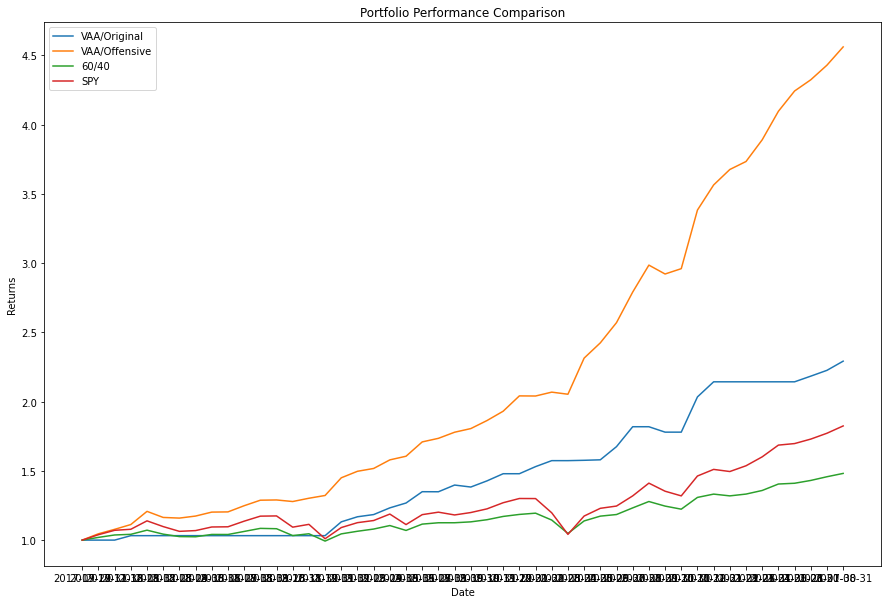

In [28]:
plt.figure(figsize=(15,10))
plt.plot(combined_df)
plt.legend(combined_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

## Investment decision based on strategy algorithm

In [29]:
offensive_momentum

,1M,3M,6M,12M,Score
SPY,0.029760,0.075040,0.187191,0.292720,1.324382
VEA,0.013132,0.000763,0.092689,0.252926,0.598946
VWO,0.021914,-0.030624,-0.004953,0.181942,0.312503
AGG,-0.003435,0.013182,0.006242,-0.019515,0.004482


In [30]:
defensive_momentum

,1M,3M,6M,12M,Score
SHY,-0.000464,-0.000811,-0.000811,-0.003581,-0.014010
IEF,-0.004588,0.024213,0.012180,-0.035717,0.030446
LQD,-0.005220,0.027257,0.022908,-0.002212,0.089988


In [ ]:
if (offensive_momentum['Score'] < 0).any():
    if (defensive_momentum['Score'] < 0).any():
        print('hold cash')
    else:
        first = defensive_momentum.sort_values(by='Score', ascending=False).index[0]
        print('invest in ' + first)
else:
    first = offensive_momentum.sort_values(by='Score', ascending=False).index[0]
    print('invest in ' + first)